In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import yt

batch = 1

# %matplotlib qt

### Parameter combinations

In [2]:
al = (0.1, 0.2, 0.4, 0.8, 1.6)
dint=(0.001, 0.002, 0.005, 0.01, 0.02)
dtrb=(0.042, 0.083, 0.17, 0.33, 0.67)

params = []

for i in al:
    for j in dint:
        for k in dtrb:
            params += [f'{i}_{j}_{k}']

### Load 3D profiles

In [3]:
profile_3d = pd.read_csv('3d/mesa20_v_LR_avg.dat')

### Load STIR profiles

In [4]:
def load_cache():
    profiles = {}
    
    for v in params:
        profiles[v] = pd.read_csv(f'.temp/profile_batch_{batch}_{v}.csv')
    
    return profiles

In [5]:
def extract_profiles():
    profiles_raw = {}

    for v in params:
        fpath = f'stir/batch_{batch}/stir_mesa20_{v}_hdf5_chk_0002'
        chk = yt.load(fpath).all_data()

        p = pd.DataFrame()
        p['r'] = chk['r']
        p['vcon'] = chk['vcon']

        p.to_csv(f'.temp/profile_batch_{batch}_{v}.csv')

        profiles_raw[v] = p    
    
    return profiles_raw

In [6]:
def interp(profiles_raw):
    profiles = {}
    r = np.array(profile_3d['r'])

    for v, p in profiles_raw.items():
        p2 = pd.DataFrame({'r': r})
        p2['vcon'] = np.interp(r, p['r'], p['vcon'])

        profiles[v] = p2
    
    return profiles

In [7]:
try:
    profiles_raw = load_cache()
except FileNotFoundError:
    profiles_raw = extract_profiles()

profiles = interp(profiles_raw)

### Calculate fits

In [8]:
l1 = []
l2 = []

for v, p in profiles.items():
    diff = p['vcon'] - profile_3d['vcon']
    l1 += [np.linalg.norm(diff, 1)]
    l2 += [np.linalg.norm(diff, 2)]
    
results = pd.DataFrame({'params': params, 
                        'l1': l1, 
                        'l2': l2})

In [9]:
mins = results.min()

min_l1 = results.iloc[results.l1.idxmin()]['params']
min_l2 = results.iloc[results.l2.idxmin()]['params']

profile_l1 = profiles[min_l1]
profile_l2 = profiles[min_l2]

### Plot

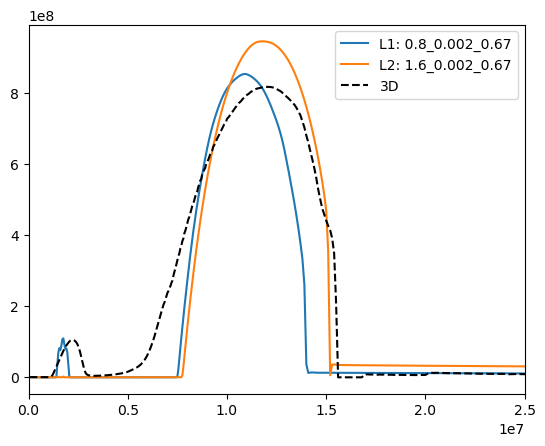

In [10]:
fig, ax = plt.subplots()

ax.set_xlim([0, 2.5e7])

ax.plot(profile_l1['r'], profile_l1['vcon'], label=f'L1: {min_l1}')
ax.plot(profile_l2['r'], profile_l2['vcon'], label=f'L2: {min_l2}')

ax.plot(profile_3d['r'], profile_3d['vcon'], ls='--', c='k', label='3D')

ax.legend()

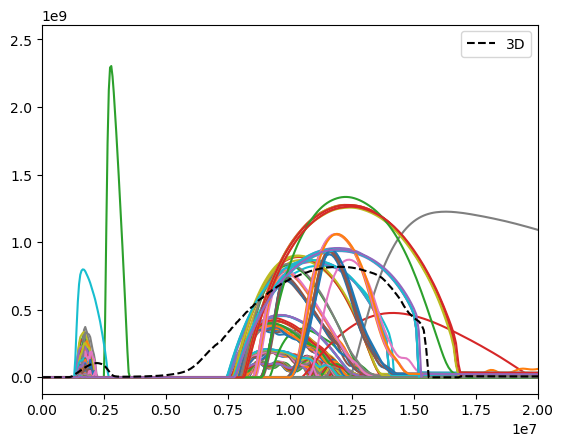

In [11]:
fig, ax = plt.subplots()

ax.set_xlim([0, 2e7])

for p in profiles.values():
    ax.plot(p['r'], p['vcon'])

ax.plot(profile_3d['r'], profile_3d['vcon'], ls='--', c='k', label='3D')
    
ax.legend()